**Nama : Shofiatul Ayu Anikaningrum**

**Kelas : TI-3F**

**No.Absen : 29**

**Materi : Recurrent Neural Network(RNN)**

# PRAKTIKUM 1
### RNN untuk Analisis Sentimen

#### Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
# Mengimpor library
import numpy as np  # NumPy untuk operasi numerik
import tensorflow_datasets as tfds  # TensorFlow Datasets untuk mengakses dan mengelola dataset
import tensorflow as tf

# Menonaktifkan tampilan progress bar dari TensorFlow Datasets untuk tampilan konsol yang lebih bersih
tfds.disable_progress_bar()


In [2]:
# Fungsi untuk menampilkan grafik performa model selama pelatihan
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  # Menampilkan grafik untuk nilai metrik pada set pelatihan dan set validasi
  plt.plot(history.history[metric])  # Garis grafik untuk set pelatihan
  plt.plot(history.history['val_'+metric], '')  # Garis grafik untuk set validasi
  plt.xlabel("Epochs")  # Label sumbu X
  plt.ylabel(metric)  # Label sumbu Y
  plt.legend([metric, 'val_'+metric])  # Menambah legenda untuk membedakan garis grafik


### Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
# Memuat dataset IMDb reviews menggunakan TensorFlow Datasets (tfds)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Membagi dataset menjadi set pelatihan dan set pengujian
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dari set pelatihan
train_dataset.element_spec


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# Mengambil satu contoh dari set pelatihan dan mencetak teks dan labelnya
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks,

label) ini:

In [5]:
# untuk mengatur set pelatihan dan pengujian
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Mengacak dan membentuk batch untuk set pelatihan
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Membentuk batch untuk set pengujian
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu contoh dari set pelatihan dan mencetak teks serta labelnya
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I was lucky enough to see this at a pre-screening last night (Oct. 20) and I was incredibly surprised by the wonderful plot and genuinely heart felt acting.<br /><br />While the plot is not particularly complicated or exceptionally new, the story unfolds in a way that feels fresh, unique, and distinctly "indy" in style. It isn\'t something that can easily be compared to films of the past, it\'s a unique take on a sort of classic middle-aged depressed love story.<br /><br />I was particularly struck by the casting of the film. Down to every last extra in the family, it was a beautiful and talented cast. The three daughters did a wonderful job, the talent was evenly dispersed between them and none of them "out-shone" the other two.<br /><br />It was truly a delightful film, appropriate for all ages and laugh out loud funny while also being truly touching and heart warming. It was a wonderful break from the sex jokes and nudity of recent films.'
 b'My friends and I rented this 

### Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:


In [6]:
#  untuk mengonfigurasi encoder untuk vektorisasi teks
VOCAB_SIZE = 1000

# Menggunakan layer TextVectorization untuk vektorisasi teks
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Mengadaptasi encoder ke set pelatihan menggunakan metode adapt
encoder.adapt(train_dataset.map(lambda text, label: text))


Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan
kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
# Kode program untuk mendapatkan 20 token pertama dari kamus vektorisasi teks
vocab = np.array(encoder.get_vocabulary())

# Menampilkan 20 token pertama dari kamus
print(vocab[:20])


['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was' 'as' 'for' 'with' 'movie' 'but']


Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  14,   1, ...,   0,   0,   0],
       [ 56, 340,   3, ...,   0,   0,   0],
       [  1, 682,  93, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()


Original:  b'I was lucky enough to see this at a pre-screening last night (Oct. 20) and I was incredibly surprised by the wonderful plot and genuinely heart felt acting.<br /><br />While the plot is not particularly complicated or exceptionally new, the story unfolds in a way that feels fresh, unique, and distinctly "indy" in style. It isn\'t something that can easily be compared to films of the past, it\'s a unique take on a sort of classic middle-aged depressed love story.<br /><br />I was particularly struck by the casting of the film. Down to every last extra in the family, it was a beautiful and talented cast. The three daughters did a wonderful job, the talent was evenly dispersed between them and none of them "out-shone" the other two.<br /><br />It was truly a delightful film, appropriate for all ages and laugh out loud funny while also being truly touching and heart warming. It was a wonderful break from the sex jokes and nudity of recent films.'
Round-trip:  i was [UNK] enoug

### Buat Model

In [10]:
# Kode program untuk membuat model Sequential dengan layer-layer yang dijelaskan di atas
model = tf.keras.Sequential([
    encoder,  # Layer vektorisasi teks
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),  # Layer embedding dengan masking
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  # Layer LSTM bidirectional
    tf.keras.layers.Dense(64, activation='relu'),  # Layer dense dengan fungsi aktivasi ReLU
    tf.keras.layers.Dense(1)  # Layer dense dengan satu output untuk klasifikasi biner
])


In [11]:
# Menampilkan informasi apakah setiap layer mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00718444]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00718444]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
# Mengompilasi model dengan konfigurasi fungsi kerugian, optimizer, dan metrik
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


### Train Model

In [15]:
# Melatih model menggunakan data pelatihan dan mengevaluasi pada data validasi
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)


Epoch 1/10
391/391 [==============================] - 53s 109ms/step - loss: 0.6538 - accuracy: 0.5738 - val_loss: 0.6367 - val_accuracy: 0.5729
Epoch 2/10
391/391 [==============================] - 28s 70ms/step - loss: 0.4675 - accuracy: 0.7708 - val_loss: 0.3917 - val_accuracy: 0.8135
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3570 - accuracy: 0.8419 - val_loss: 0.3719 - val_accuracy: 0.8552
Epoch 4/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3303 - accuracy: 0.8566 - val_loss: 0.3380 - val_accuracy: 0.8401
Epoch 5/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3148 - accuracy: 0.8650 - val_loss: 0.3233 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3075 - accuracy: 0.8685 - val_loss: 0.3315 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3034 - accuracy: 0.8710 - val_loss: 0.3200 - val_accuracy

In [16]:
# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_dataset)

# Menampilkan hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 14s 36ms/step - loss: 0.3177 - accuracy: 0.8626
Test Loss: 0.3177188038825989
Test Accuracy: 0.862559974193573


(0.0, 0.6716650679707528)

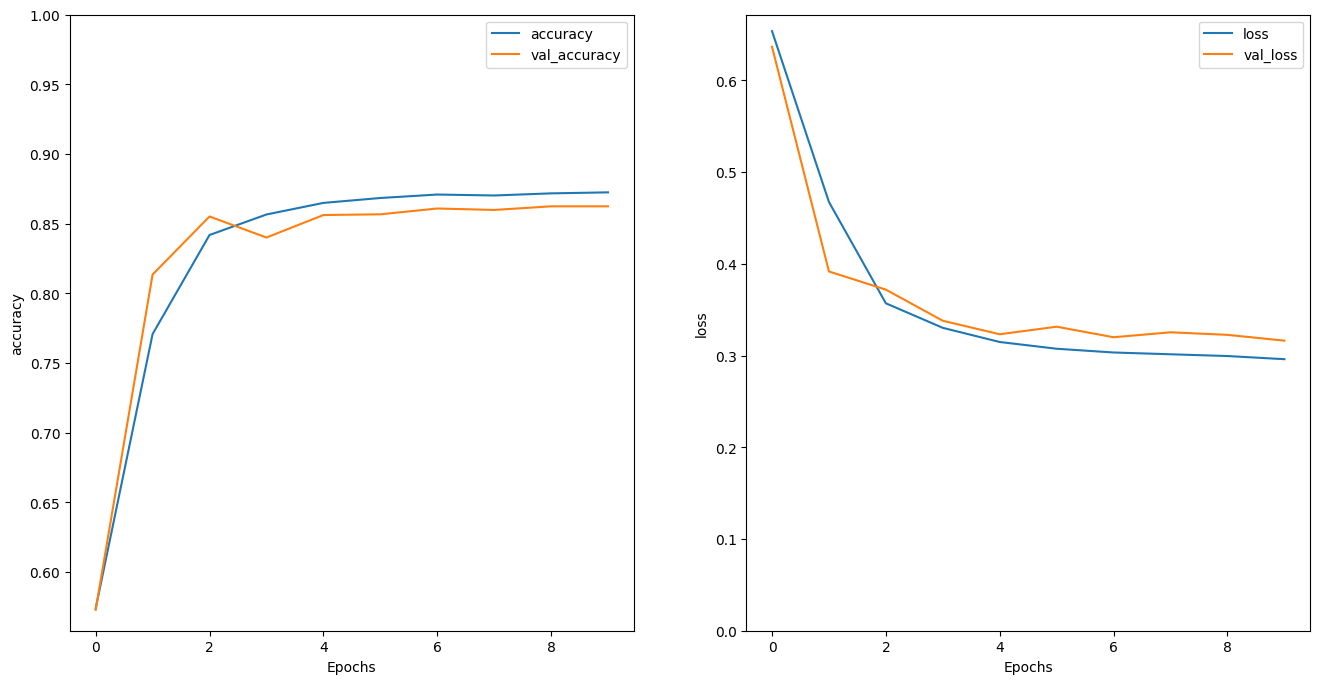

In [17]:
# Menampilkan plot grafik untuk akurasi dan loss
plt.figure(figsize=(16, 8))

# Plot akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

# Plot loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [18]:
# Contoh teks untuk diprediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi menggunakan model
predictions = model.predict(np.array([sample_text]))


1/1 [==============================] - 3s 3s/step


### Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [19]:
# Membangun model dengan struktur yang kompleks
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [20]:
# Mengompilasi model dengan konfigurasi fungsi kerugian, optimizer, dan metrik
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


In [21]:
# Melatih model dengan data pelatihan dan validasi
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)


Epoch 1/10
391/391 [==============================] - 78s 153ms/step - loss: 0.6320 - accuracy: 0.5822 - val_loss: 0.5057 - val_accuracy: 0.7349
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.4032 - accuracy: 0.8262 - val_loss: 0.3656 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3406 - accuracy: 0.8556 - val_loss: 0.3373 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3198 - accuracy: 0.8659 - val_loss: 0.3269 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3113 - accuracy: 0.8691 - val_loss: 0.3265 - val_accuracy: 0.8646
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3062 - accuracy: 0.8694 - val_loss: 0.3209 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3035 - accuracy: 0.8707 - val_loss: 0.3496 - val_ac

In [22]:
# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_dataset)

# Menampilkan hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 21s 53ms/step - loss: 0.3211 - accuracy: 0.8640
Test Loss: 0.3210526406764984
Test Accuracy: 0.8640400171279907


In [23]:
# Melakukan prediksi pada teks sampel tanpa padding
sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Melakukan prediksi menggunakan model
predictions = model.predict(np.array([sample_text]))

# Menampilkan hasil prediksi
print(predictions)


1/1 [==============================] - 6s 6s/step
[[-1.7392342]]


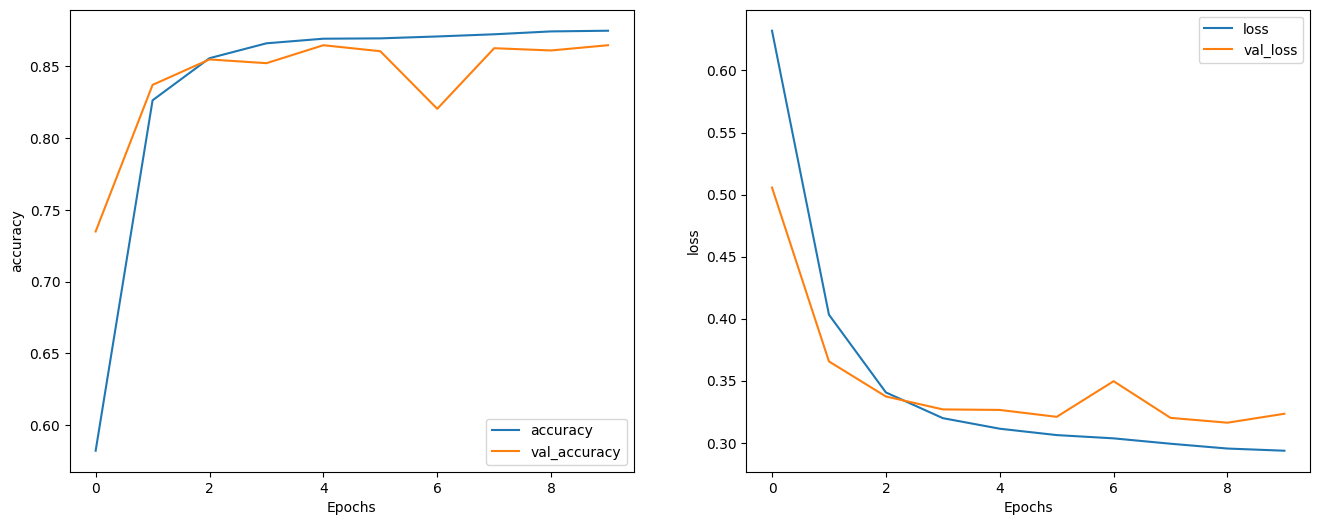

In [24]:
# Menampilkan grafik akurasi dan loss dari training history
plt.figure(figsize=(16, 6))

# Menampilkan subplot untuk akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

# Menampilkan subplot untuk loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
